<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [32]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Configuración de pandas
# --------------------------------------------

import warnings
warnings.filterwarnings('ignore')

# Para hacer visualizaciones
# -------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
# Importamos nuesto archivo cn las funciones de soporte
from src import soporte_nlp as snlp

In [35]:
df = pd.read_csv("datos/datos.csv", index_col=0)
df.head()


,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
26571,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
40292,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
5884,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 65115 to 43619
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            10000 non-null  object 
 1   reviewDate          10000 non-null  object 
 2   mainDepartment      10000 non-null  object 
 3   subDepartment       10000 non-null  object 
 4   productName         10000 non-null  object 
 5   reviewTitle         9995 non-null   object 
 6   reviewStar          10000 non-null  float64
 7   reviewText          9999 non-null   object 
 8   inconsistentStatus  10000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 781.2+ KB


En primer lugar, filtramo spara quedarnos con las columnas que nos interesan

In [37]:
df = df[['productName', 'reviewText', 'mainDepartment']]

In [38]:
df.head()

,productName,reviewText,mainDepartment
65115,Doctor Developed Copper Wrist Brace / Carpal T...,Nice lightweight brace but unfortunately was t...,Sports and Outdoors
56720,Fruit of the Loom Men's Coolzone Boxer Briefs,Boxers were ok. The color did start to fade pr...,Computers
26571,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Very easy to install. Worked right away but it...,Computers
40292,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",The color is completely different than hunter ...,Home and Kitchen
5884,WOW Apple Cider Vinegar Shampoo and Hair Condi...,"From reading the reviews, I was hoping that th...",Beauty and Personal Care


Eliminamos el unico nulo que hay en "reviewText".

In [39]:
df = df.dropna(subset=["reviewText"]).reset_index(drop = True)

In [40]:
df

,productName,reviewText,mainDepartment
0,Doctor Developed Copper Wrist Brace / Carpal T...,Nice lightweight brace but unfortunately was t...,Sports and Outdoors
1,Fruit of the Loom Men's Coolzone Boxer Briefs,Boxers were ok. The color did start to fade pr...,Computers
2,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Very easy to install. Worked right away but it...,Computers
3,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",The color is completely different than hunter ...,Home and Kitchen
4,WOW Apple Cider Vinegar Shampoo and Hair Condi...,"From reading the reviews, I was hoping that th...",Beauty and Personal Care
...,...,...,...
9994,"Etekcity Food Kitchen Scale, Digital Grams and...",This scale is great for food prep. It is fast ...,Home and Kitchen
9995,Saucony Men's Multi-Pack Mesh Ventilating Comf...,Comfortable but a little small. Rides down on...,Sports and Outdoors
9996,Wilson Soft Play Volleyball,Really great volleyball for the water!! Only p...,Sports and Outdoors
9997,Fruit of the Loom Men's Coolzone Boxer Briefs,Good fit and comfortable to wear.,Computers


Nos quedamos con los valroes unicos de la columna producto, en función de los cuales vamos a agrupar

In [41]:
df['productName'].nunique()

99

In [42]:
df = df.groupby(['productName', 'mainDepartment']).agg({
    'reviewText': ' '.join
}).reset_index()


In [43]:
df.head()

,productName,mainDepartment,reviewText
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Bought for school work. Doing good so far.Slee...


In [44]:
df["reviewText"][0]

'I’ll admit I was very skeptical from reviews but I decided to purchase anyways…. and so far so good! Battery life is about 7 hours of constant use (games, videos, etc). Sounds is good. I had no problems connecting to internet. The border of the phone did appear to have some scratches but not too many. The phone I received has a loose charging port that should have been replaced. It was at 27% just now and I plugged it in and opened an app. Now it just gave me the under 20% notification so it’s obviously struggling to keep the cord in place. No working well can\'t download any apps horrible phone My old Android works better than this junk. Please refund money. Diana Manuele It’s for personal and the battery life issues is crazy it’s only take 2 hours Worked slow, barely charged. Battery life is not good at all. Only last an hour. The worse I never bought. Battery is dead and I sent it in Africa, so no way to return it. Just lost my money. I could give 0 star I’m very picky with my phon

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   productName     99 non-null     object
 1   mainDepartment  99 non-null     object
 2   reviewText      99 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB
None

Descripción del DataFrame:
               count unique  \
productName       99     99   
mainDepartment    99      5   
reviewText        99     99   

                                                              top freq  
productName     (Refurbished) Apple iPhone 7, 32GB, Black - Fu...    1  
mainDepartment                                          Computers   36  
reviewText      I’ll admit I was very skeptical from reviews b...    1  

Distribución de clases en la columna 'productName':
productName
(Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked                                      

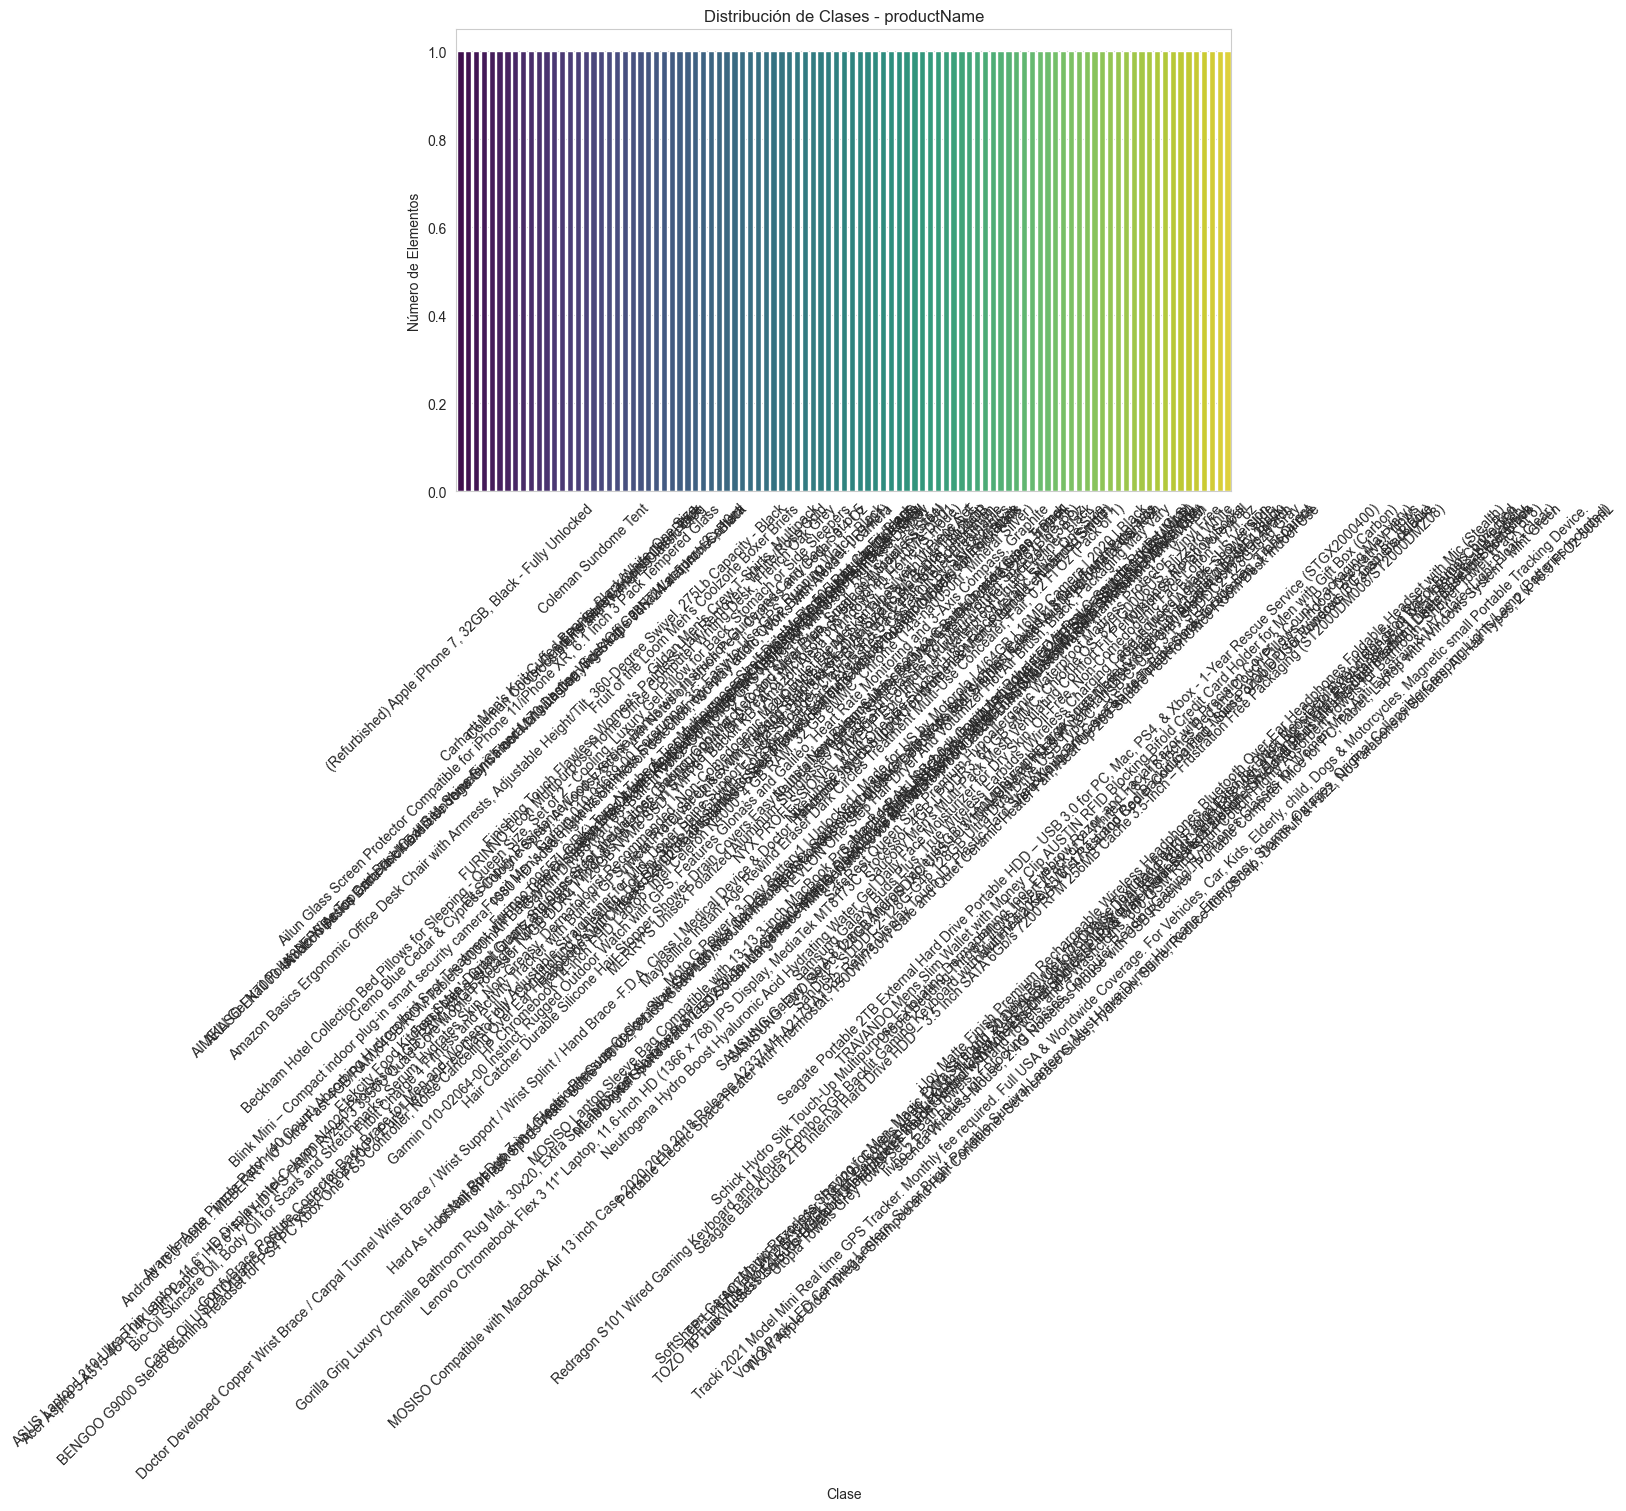

Limpiando el texto...
Texto limpiado y listo.


,productName,mainDepartment,reviewText,cleaned_text
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,I’ll admit I was very skeptical from reviews b...,admit skeptical review decide purchase anyway ...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"It’s thick, but works good once you get used t...",thick work good get use base top coat work gre...
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,I was not impressed with the image quality. A...,impressed image quality also app suggest use p...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,The laptop arrived just in time for school!! W...,laptop arrive time school work great product d...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Bought for school work. Doing good so far.Slee...,buy school work good farsleek alright buy lapt...


In [45]:
# Instanciar la clase con las columnas relevantes
exploracion = snlp.ExploracionText(dataframe=df, text_column='reviewText', label_column='productName', language="english")

# Explorar los datos
exploracion.explorar_datos()

# Limpiar los textos
exploracion.limpiar_textos("cleaned_text")

# Obtener el DataFrame limpio
df_limpio = exploracion.obtener_dataframe_limpio()

# Ver las primeras filas del DataFrame limpio
df_limpio.head()

In [46]:
# Realizamos la vectorización
vectorizer = CountVectorizer(max_features=1000, stop_words='english')


In [47]:
X = vectorizer.fit_transform(df['reviewText']).toarray()
X

array([[4, 5, 0, ..., 0, 0, 0],
       [2, 2, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 1, 1, 0],
       [0, 0, 1, ..., 1, 0, 0]])

In [48]:
similarity = cosine_similarity(X)
similarity

array([[1.        , 0.23041809, 0.40166767, ..., 0.33186467, 0.24643662,
        0.32067562],
       [0.23041809, 1.        , 0.33466591, ..., 0.31801446, 0.2863927 ,
        0.31045757],
       [0.40166767, 0.33466591, 1.        , ..., 0.4517069 , 0.30855501,
        0.36165599],
       ...,
       [0.33186467, 0.31801446, 0.4517069 , ..., 1.        , 0.42048029,
        0.34925173],
       [0.24643662, 0.2863927 , 0.30855501, ..., 0.42048029, 1.        ,
        0.32918897],
       [0.32067562, 0.31045757, 0.36165599, ..., 0.34925173, 0.32918897,
        1.        ]])

In [49]:
def get_index_from_name(name):
    return df[df.productName == name].index[0]

def get_name_from_index(index):
    return df[df.index == index]['productName'].values[0]


In [50]:
# Elegimos un producto al azar
random_product = df['productName'].sample(1).iloc[0] 

In [51]:
# Buscamos el indice del juego
game_index = get_index_from_name(random_product) 
game_index

np.int64(72)

In [52]:
# Analizamos la similitud del juego con los demás
similarity[game_index]

array([0.20659756, 0.28483559, 0.28530119, 0.26591078, 0.2798154 ,
       0.27701895, 0.21719358, 0.20492562, 0.09599332, 0.31196794,
       0.2986931 , 0.26606783, 0.2962534 , 0.2514017 , 0.24959921,
       0.25438217, 0.21004178, 0.28179133, 0.31247391, 0.26576807,
       0.21807952, 0.23084883, 0.20831626, 0.27116485, 0.21086737,
       0.34175363, 0.29073559, 0.2904624 , 0.18544604, 0.16620656,
       0.3701019 , 0.32607941, 0.05701176, 0.24408611, 0.20919807,
       0.31490734, 0.22817997, 0.35475986, 0.30980852, 0.22559052,
       0.23193524, 0.20349777, 0.22964793, 0.31995676, 0.2305816 ,
       0.29076   , 0.2476108 , 0.28267082, 0.32040972, 0.12491078,
       0.32547934, 0.30541134, 0.37329462, 0.17906688, 0.35639673,
       0.20270739, 0.11195177, 0.1820351 , 0.33545992, 0.29961548,
       0.31030718, 0.23922762, 0.31140421, 0.27832567, 0.31650307,
       0.27735027, 0.25602632, 0.32383788, 0.19206339, 0.26399526,
       0.22060688, 0.26970954, 1.        , 0.29270386, 0.14366

In [53]:
similar_games=list(enumerate(similarity[game_index]))

In [54]:
# Hacemos un top 10 de los juegos
sorted_games =sorted(similar_games, key=lambda x: x[1], reverse=True) 
top10_game ={}
for i in sorted_games[1:11]:
    top10_game[get_name_from_index(i[0])]=i[1]
    print(i)
top10_game

(52, np.float64(0.37329461872941566))
(30, np.float64(0.3701019048818244))
(54, np.float64(0.3563967273066457))
(37, np.float64(0.35475985685959194))
(25, np.float64(0.3417536308696365))
(58, np.float64(0.33545992382572243))
(31, np.float64(0.3260794147795815))
(50, np.float64(0.32547933715522354))
(67, np.float64(0.32383787803618075))
(81, np.float64(0.3224908744645586))


{'Magic Bullet Blender, Small, Silver, 11 Piece Set': np.float64(0.37329461872941566),
 "Fruit of the Loom Men's Coolzone Boxer Briefs": np.float64(0.3701019048818244),
 'Maybelline Instant Age Rewind Eraser Dark Circles Treatment Multi-Use Concealer, Fair, 0.2 Fl Oz (Pack of 1)': np.float64(0.3563967273066457),
 'Gorilla Grip Luxury Chenille Bathroom Rug Mat, 30x20, Extra Soft and Super Absorbent Shaggy Rugs, Machine Washable, Quick Dry Bathmat, Plush Carpet for Tub, Shower and Bath Room Floor Mats, Grey': np.float64(0.35475985685959194),
 "Finishing Touch Flawless Women's Painless Hair Remover , White/Rose Gold": np.float64(0.3417536308696365),
 'NYX PROFESSIONAL MAKEUP Epic Ink Liner, Waterproof Liquid Eyeliner, Black': np.float64(0.33545992382572243),
 'Furinno (99557LC/BK) Turn-N-Tube 4-Tier Multipurpose Shelf Display Rack - Light Cherry/Black': np.float64(0.3260794147795815),
 'MOSISO Compatible with MacBook Air 13 inch Case 2020 2019 2018 Release A2337 M1 A2179 A1932 Retina Disp

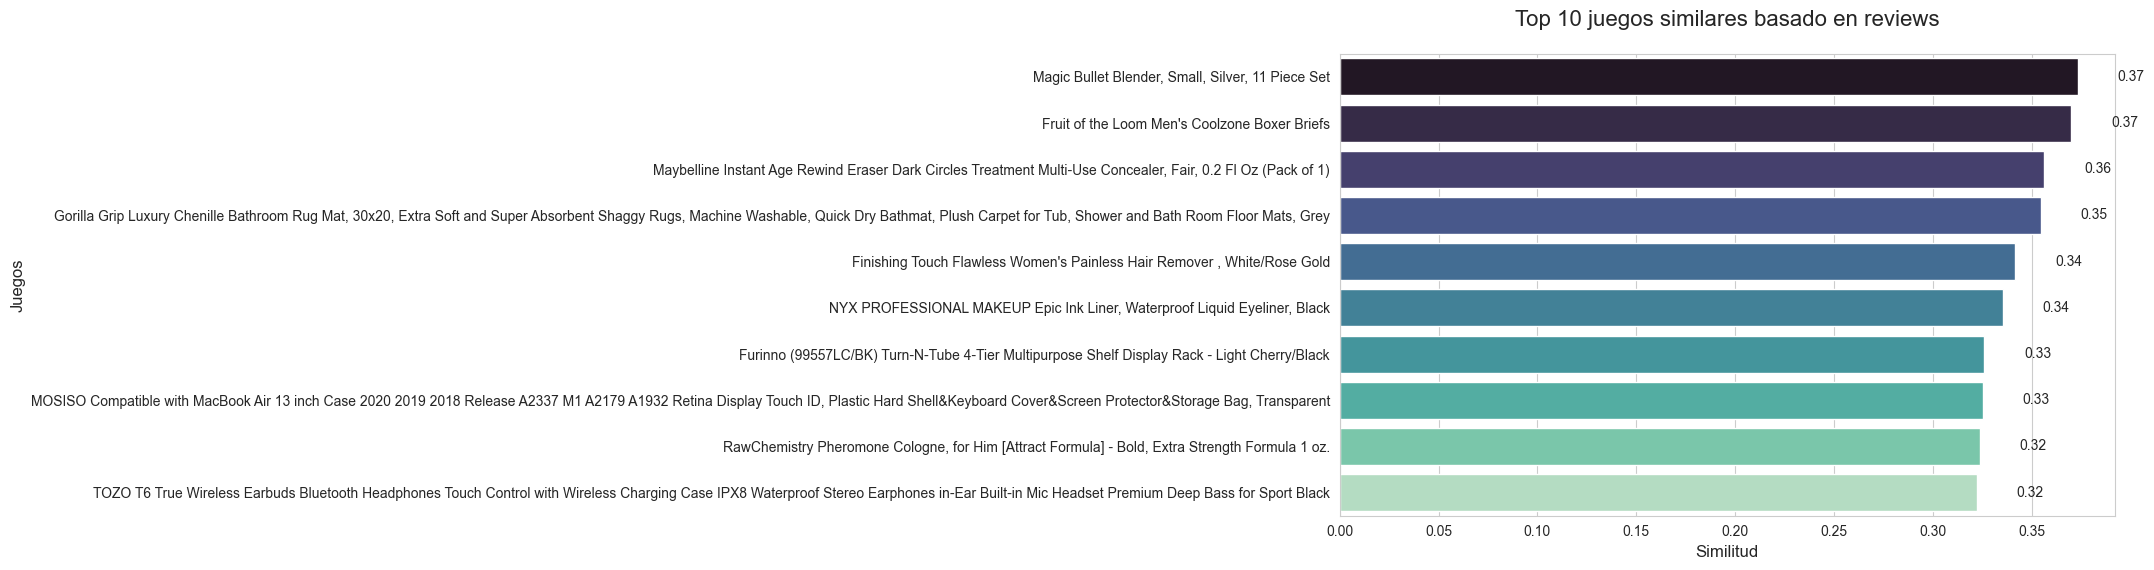

In [55]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(top10_game.values()), 
    y=list(top10_game.keys()), 
    palette="mako"
)

plt.title("Top 10 juegos similares basado en reviews", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Juegos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top10_game.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()

# Caso 2: Sistema de Recomendación Basado en Popularidad

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   productName     99 non-null     object
 1   mainDepartment  99 non-null     object
 2   reviewText      99 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB


Guardamos los datos como csv

In [57]:
df.to_csv('datos/datos_agruados.csv')

In [58]:
# Instanciamos la clase par analizar sentimientos
sentimiento = snlp.AnalisisSentimientos(df, columna_texto='reviewText')